# Scanning Mobility Prticle Sizer Spectrometer (SMPS) Analysis & Fits
---------------------------

preprocessing SMPS <i>FIREX</i> data for SOM-TOMAS (COSO). Fit the first couple of data points after inflection time to feed COSO. <br />

---------------------------------

Import all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly as ply
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline

Define Gaussian funtion to fit SMPS data.

In [2]:
def size_func(dp,nt,dp_m,sgma):
    return (nt/(((2.*np.pi)**.5)*np.log(sgma)))*\
           np.exp(-1.0*((np.log(dp)-np.log(dp_m))**2.)\
                  /(2.*(np.log(sgma)**2.)))*2.303

Read SMPS FIREX Data and converting to an array and reduce the dimension.

In [3]:
dNdlogDp = np.array(pd.read_excel('../Data/fire004_h2o2_smps.xlsx', sheet_name='no_conc', header=None))
time = np.squeeze(np.array(pd.read_excel('../Data/fire004_h2o2_smps.xlsx', sheet_name='time')))
dlr = np.squeeze(np.array(pd.read_excel('../Data/fire004_h2o2_smps.xlsx', sheet_name='dlr')))
dp = np.squeeze(np.array(pd.read_excel('../Data/fire004_h2o2_smps.xlsx', sheet_name='dp')))

Rough estimation of the first bin bound:

In [4]:
dp0 = dp[0]/np.mean(dp[1:]/dp[:-1])

Calculattion of dlogD<sub>p</sub>:

In [5]:
dlogDp = np.array([i for i in np.log10(dp[1:]/dp[:-1])])
dlogDp = np.insert(dlogDp, 0, np.mean(dp[1:]/dp[:-1]))

Calculation total number concentration ($\frac{dN}{dlogD_p}\ \times\ dlogD_p$) and correcting for dilution.

In [6]:
Nt = np.sum(dNdlogDp*dlogDp, axis=1)*dlr

Ploting the total number concentration over time

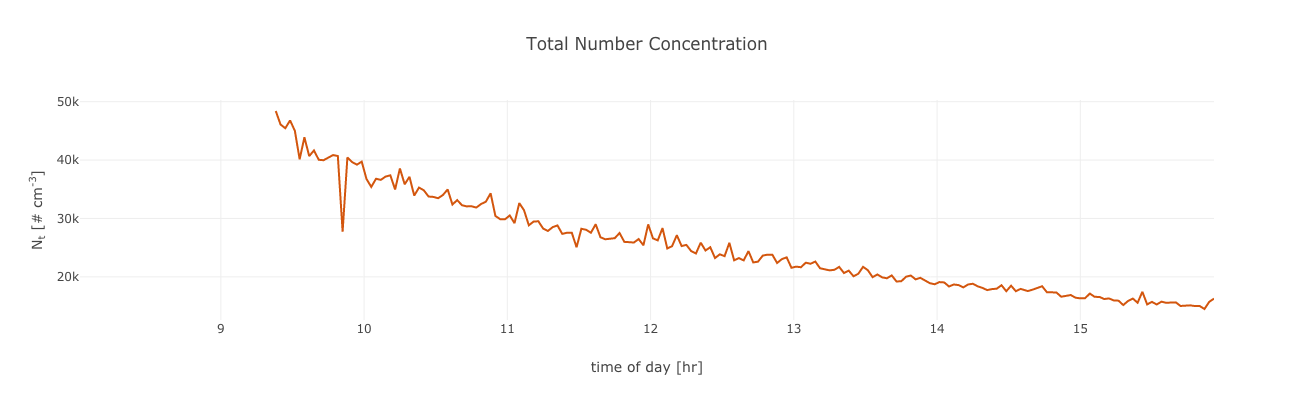

In [7]:
total_num = go.Scatter(x = time/3600., y = Nt, mode = 'lines', marker=dict(color='#d3560e'))
data = [total_num]

layout= go.Layout(width=600,
                  height=400,
                  title= 'Total Number Concentration',
                  hovermode= 'closest',
                  xaxis= dict(title= 'time of day [hr]',
                              #ticklen= 1,
                              dtick=1,
                              zeroline= False,
                              #gridwidth= 1,
                             ),
                  yaxis=dict(title= 'N<sub>t</sub> [# cm<sup>-3</sup>]',
                             #ticklen= 5,
                             #gridwidth= 2,
                            ),
                  showlegend= False)

fig= go.Figure(data=data, layout=layout)
ply.offline.iplot(fig, filename='total_number_conc')

dilution correction of the number concentration for every bin.

In [8]:
dNdlogDp_dlr = np.transpose(np.transpose(dNdlogDp)*dlr)

Find the index where the dilution ratio is not NaN to start from inflection point of the experiment.

In [9]:
ind = np.where(~np.isnan(dlr))[0][0]

Take an average of the first 3 points which coressponds to first 6 mins

In [10]:
dNdlogDp1 = np.mean(dNdlogDp_dlr[ind:ind+3,:], axis=0)

Plot the averaged size distribution and the other 3 points after inflection points.

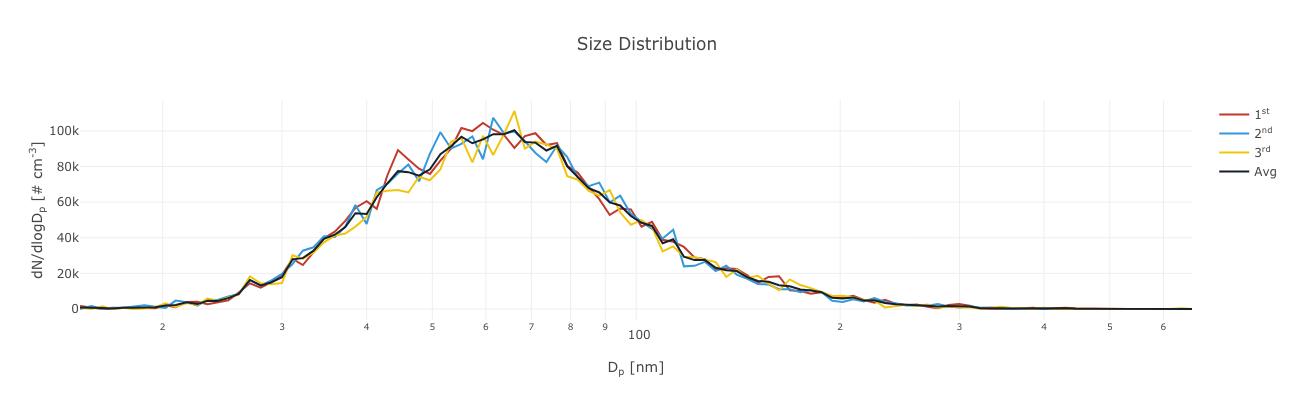

In [11]:
first = go.Scatter(x=dp, y=dNdlogDp[ind], mode='lines', name='1<sup>st</sup>', marker=dict(color='#C0392B'))
second = go.Scatter(x=dp, y=dNdlogDp[ind+1], mode='lines', name='2<sup>nd</sup>', marker=dict(color='#3498DB'))
third = go.Scatter(x=dp, y=dNdlogDp[ind+2], mode='lines', name='3<sup>rd</sup>', marker=dict(color='#F1C40F'))
avg = go.Scatter(x=dp, y=dNdlogDp1, mode='lines', name='Avg', marker=dict(color='#17202A'))

data = [first, second, third, avg]

layout= go.Layout(width=600,
                  height=400,
                  title= 'Size Distribution',
                  hovermode= 'closest',
                  xaxis= dict(title= 'D<sub>p</sub> [nm]',
                              #ticklen= 1,
                              #dtick=1,
                              type='log',
                              zeroline= False,
                              #gridwidth= 1,
                             ),
                  yaxis=dict(title= 'dN/dlogD<sub>p</sub> [# cm<sup>-3</sup>]',
                             #ticklen= 5,
                             #gridwidth= 2,
                             zeroline=False,
                            ),
                  showlegend= True)

fig= go.Figure(data=data, layout=layout)
ply.offline.iplot(fig, filename='dNdlogDp')

Fit the averaged size distribution.

In [12]:
popt, pcov = curve_fit(size_func, dp, dNdlogDp1, p0=[5000, 70, 1.5])
popt

array([4.50884376e+04, 6.23842462e+01, 1.53798448e+00])

Create the fit size distribution based on the fit values above.

In [13]:
dNdlogDp_fit = size_func(dp, popt[0], popt[1], popt[2])

Plot the fit and the averaged size distribution to see if they matched.

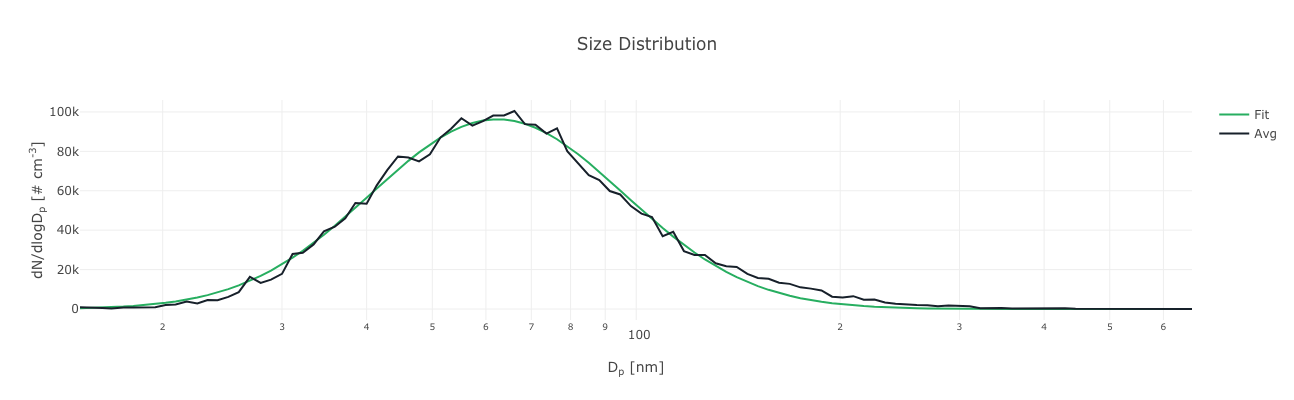

In [14]:
avg = go.Scatter(x=dp, y=dNdlogDp1, mode='lines', name='Avg', marker=dict(color='#17202A'))
fit = go.Scatter(x=dp, y=dNdlogDp_fit, mode='lines', name='Fit', marker=dict(color='#27AE60'))

data = [fit, avg]

layout= go.Layout(width=600,
                  height=400,
                  title= 'Size Distribution',
                  hovermode= 'closest',
                  xaxis= dict(title= 'D<sub>p</sub> [nm]',
                              #ticklen= 1,
                              #dtick=1,
                              type='log',
                              zeroline= False,
                              #gridwidth= 1,
                             ),
                  yaxis=dict(title= 'dN/dlogD<sub>p</sub> [# cm<sup>-3</sup>]',
                             #ticklen= 5,
                             #gridwidth= 2,
                             zeroline=False,
                            ),
                  showlegend= True)

fig= go.Figure(data=data, layout=layout)
ply.offline.iplot(fig, filename='dNdlogDp')

Print the final fit parameter.

In [15]:
print('1- Total Number Concentration (Nt) = %10.2f'%popt[0])
print('2- Median Diameter (Dpm) = %5.2f'%popt[1])
print('3- width of distribution (sigma) = %5.3f'%popt[2])

1- Total Number Concentration (Nt) =   45088.44
2- Median Diameter (Dpm) = 62.38
3- width of distribution (sigma) = 1.538
